<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/Amazon_Employee_Access_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# 2nd July, 2023


Keep 'resource' aside while transforming features
Still get comparable results to xgboost
on full data with 'resource'

"""

In [ ]:
# Mount gdrive:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
## Cleanup
# Maybe these folders exist. Remove them
! rm -r -f /content/allmodels
! rm -r -r /content/datafiles
! rm -r -f /content/transformer.pkl


# And if gdrive is connected:
!rm -r -f  /gdrive/MyDrive/Colab_data_files/allmodels
!rm -r -f /gdrive/MyDrive/Colab_data_files/amazonemp

rm: cannot remove '/content/datafiles': No such file or directory


## Basics
Install software and call libraries

In [1]:
!pip install catencfamily==0.0.82

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.5 MB/s eta 0:00:00


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [3]:
# 1.0 Call libraries
import pandas as pd
import numpy as np



# 1.01
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report,f1_score,roc_auc_score



# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community

# 1.03
import xgboost as xgb
import optuna
import imblearn
from imblearn.over_sampling import SMOTE


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.05
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')


Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [4]:
# 1.06 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [5]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(0)

In [6]:
# Some constants:
amazonfolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/"

amazongraphs = "/gdrive/MyDrive/Colab_data_files/amazonemp/models/"
amazondata = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/"
estPath = "/gdrive/MyDrive/Colab_data_files/amazonemp/estimators/"
unitvecfolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/unitvec/"


## Read data
Read and pop-out unwanted features

In [ ]:
# 2.0 Read Data:
url_tr = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/train.csv"
url_te = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/test.csv"
train = pd.read_csv(url_tr)
test = pd.read_csv(url_te)   # Does not contain action columns

In [ ]:
# 2.0.1
train.head(3)
test.head(3)


,action,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880


,id,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175


In [ ]:
# 2.0.2
train.shape     # (32769, 10)
test.shape      # (58921, 10)
train.columns

(32769, 10)

(58921, 10)

Index(['action', 'resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo',
       'roledeptname', 'roletitle', 'rolefamilydesc', 'rolefamily',
       'rolecode'],
      dtype='object')

In [ ]:
# 2.0.3
y = train.pop("action")
_= test.pop("id")


In [ ]:
# 2.0.4 Is data balanced? No.
y.value_counts()
y.value_counts(normalize = True)  # 95%:6%


1    30872
0     1897
Name: action, dtype: int64

1    0.94211
0    0.05789
Name: action, dtype: float64

In [ ]:
# 2.0.5 Let us denote minority class as 1 and majority as 0:
y = 1-y

In [ ]:
# 2.0.6 Check nulls. None.
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

In [ ]:
# 2.0.7 Check again
y.value_counts()
y.value_counts(normalize = True)  # 95%:6%


0    30872
1     1897
Name: action, dtype: int64

0    0.94211
1    0.05789
Name: action, dtype: float64

## Partition data
`X_train/X_test`

In [ ]:
## 3.0 Developing models
X_train, X_test, y_train,y_test = train_test_split(train,
                                                   y,
                                                   test_size=0.25,
                                                   stratify=y,
                                                   random_state=rng)

In [ ]:
# 3.0.1
X_train.shape  #  (24576, 9)
X_test.shape   #  (8193, 9)
y_train.shape  # (24576,)
y_test.shape   # (8193,)



(24576, 9)

(8193, 9)

(24576,)

(8193,)

In [ ]:
# 3.0.2
X_train.head(2)
X_test.head(2)

,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17277,4675,18044,117961,118386,118522,118321,117906,290919,118322
9292,73495,51345,117961,118052,120417,118702,125047,118704,118705


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
12953,110357,52687,117961,117962,117904,128230,302830,4673,128231
17348,41269,3889,117961,118386,121668,118321,117906,290919,118322


In [ ]:
# 3.1 No of unique values in columns:

for i in train.columns:
  print(f"No of unique values in '{i}' are:           \t\t{train[i].nunique()}")

No of unique values in 'resource' are:           		7518
No of unique values in 'mgrid' are:           		4243
No of unique values in 'rolerollupOne' are:           		128
No of unique values in 'rolerolluptwo' are:           		177
No of unique values in 'roledeptname' are:           		449
No of unique values in 'roletitle' are:           		343
No of unique values in 'rolefamilydesc' are:           		2358
No of unique values in 'rolefamily' are:           		67
No of unique values in 'rolecode' are:           		343


## Instantiate `CatEncodersFamily` class and fit on X_train
Instantiate `CatEncodersFamily` class and fit it on `X_train`

In [ ]:
# 4.0 Which are our cat columns?
#     We will consider for transformation
#     all columns but 'resource'

cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

len(cat_cols)  # 8. 'resource' is not included

# Keep interacting columns an empty list
interactingCatCols = []


8

In [ ]:
# 4.1 Instantiate CatEncodersFamily class. We will also save
#     graphs created:
#     Folder  /content/allmodels/models created to deposit cat encoder models and graph related files

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,0,None,1,1],
                       saveGraph = True,
                       k = 40
                       )

# 4.2 Fit it using only X_train.
#     While fitting, 'target' is not needed.
#     Takes time...

ct.fit(X_train,
       cat_cols,
       interactingCatCols
       )

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('mgrid', 'rolerollupOne', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('rolerolluptwo', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('rolerolluptwo', 'rolerollu

CatEncodersFamily(k=40, modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:
Transform `X_train` and `X_test` using fitted `CatEncodersFamily` object

In [ ]:
# 5.0 Transform both X_test and X_train data:

test_trans = ct.transform(X_test[cat_cols])

f"Transformed test data shape: {test_trans.shape}"  #  (8193, 218)



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 14.354136 MB
Mem usage after dtype transformation is: 7.472016 MB


'Transformed test data shape: (8193, 218)'

In [ ]:
# 5.0.1 Transform X_train now:

train_trans= ct.transform(X_train[cat_cols])

f"Transformed train data shape: {train_trans.shape}" # Transformed train data shape: (24576, 218)



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 43.057152 MB
Mem usage after dtype transformation is: 22.413312 MB


'Transformed train data shape: (24576, 218)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 5.2 Observe data now:
#     It also has original binned cols (6):

train_trans.head(3)
test_trans.head(3)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,18044,117961,118386,118522,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.036717,0.057254,0.083832,0.212401,0.009444,0.007352,0.029940,3.853129e-17,0.003087
1,51345,117961,118052,120417,118702,125047,118704,118705,0.421883,0.024354,...,0.005207,0.008848,0.010622,0.023952,0.010817,0.004082,0.003733,0.005988,-2.580549e-18,0.003087
2,14952,117961,117962,119223,119962,168365,118205,119964,0.421883,0.024354,...,0.006909,0.003972,-0.005040,0.056886,0.191159,0.006110,0.000326,0.011976,-3.151965e-17,0.003087


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,52687,117961,117962,117904,128230,302830,4673,128231,0.421883,0.024354,...,0.005049,0.002312,-0.033409,0.005988,-1.413484e-18,0.003894,0.000000,0.008982,-9.564134e-18,0.003087
1,3889,117961,118386,121668,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.036717,0.057254,0.083832,2.124007e-01,0.009444,0.007352,0.029940,3.853129e-17,0.003087
2,21135,117961,118343,123494,118784,121926,290919,118786,0.421883,0.024354,...,0.011398,0.031949,0.011132,0.092814,2.272589e-01,0.010813,0.016084,0.029940,1.538734e-17,0.003087


In [ ]:
# 5.3
train_trans.shape   #   (24576, 218)
test_trans.shape    #  (8193, 218)

(24576, 218)

(8193, 218)

In [ ]:
# 5.4 Save ct to current folder:
utils.savePythonObject(ct, "transformer.pkl")

Object saved to: /content/transformer.pkl


## Make an archive of files in gdrive
Save `X_train/X_test`, `CatEncodersFamily` object and transformed data to your gdrive for subsequent use


In [ ]:
# 6.1 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [ ]:
# 6.2.1 Delete if a folder already exists on gdrive:
outputfolder = Path(amazonfolder)
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [ ]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/amazonemp/models.zip'

In [ ]:
# 6.4 Let us have a look at our list of (graph) stored files:
graphfolder = Path(amazongraphs)
p = graphfolder.glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/roledeptname_bigraph_rolecode.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/roledeptname_projected_mgrid.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/rolefamilydesc_bigraph_roletitle.gml')]

### Archive of datafiles

#### Save first to local destination

In [ ]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)


# 6.5.1 Full file paths:
#       Our train/test data
trfile = destination / "X_train.pkl"
tefile = destination / "X_test.pkl"
ytr = destination / "y_train.pkl"
yte = destination / 'y_test.pkl'

# 6.5.2 Our transformed data
trtrans = destination / 'train_trans.pkl'
tetrans = destination / 'test_trans.pkl'


# 6.5.3 Now save
X_train.to_pickle(trfile)
X_test.to_pickle(tefile)
y_train.to_pickle(ytr)
y_test.to_pickle(yte)
train_trans.to_pickle(trtrans)
test_trans.to_pickle(tetrans)

#### Transfer from local to gdrive

In [ ]:
# 6.6 Delete if a folder already exists on gdrive:
outputfolder = Path(amazondata)
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [ ]:
# 6.6.1 Archive folder where pickle files are stored to gdrive
output_filename = outputfolder
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.6.2 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles.zip'

### Archive of transformer object

In [ ]:
# 6.7 Also copy 'transformer.pkl' to gdrive
#datafolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/"
shutil.copy('/content/transformer.pkl', amazondata + 'transformer.pkl')


'/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/transformer.pkl'

### Our data files on gdrive

In [ ]:
# 6.8 Let us have a look at our list of pickled data files:
datafolder = Path(amazondata)
p = datafolder.glob('**/*')
files = [x for x in p if x.is_file()]
files
len(files)  # 7

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/y_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/X_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/y_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/X_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/transformer.pkl')]

7

## Read back archived datafiles
Read back saved objects and data files from gdrive archive

In [7]:
# 7.0
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
# 7.1

X_train = pd.read_pickle(amazondata + "X_train.pkl")
X_test = pd.read_pickle(amazondata+ "X_test.pkl")
y_train = pd.read_pickle(amazondata + "y_train.pkl")
y_test = pd.read_pickle(amazondata + "y_test.pkl")

train_trans = pd.read_pickle(amazondata +"train_trans.pkl")
test_trans = pd.read_pickle(amazondata + "test_trans.pkl")
ct = pd.read_pickle(amazondata + "transformer.pkl")

In [9]:
# 7.0.1 Check
train_trans.shape  # (24576, 218)
test_trans.shape  # (8193, 218)
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

(24576, 218)

(8193, 218)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,18044,117961,118386,118522,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.036717,0.057254,0.083832,0.212401,0.009444,0.007352,0.029940,3.853129e-17,0.003087
1,51345,117961,118052,120417,118702,125047,118704,118705,0.421883,0.024354,...,0.005207,0.008848,0.010622,0.023952,0.010817,0.004082,0.003733,0.005988,-2.580549e-18,0.003087


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,52687,117961,117962,117904,128230,302830,4673,128231,0.421883,0.024354,...,0.005049,0.002312,-0.033409,0.005988,-1.413484e-18,0.003894,0.000000,0.008982,-9.564134e-18,0.003087
1,3889,117961,118386,121668,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.036717,0.057254,0.083832,2.124007e-01,0.009444,0.007352,0.029940,3.853129e-17,0.003087


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17277,4675,18044,117961,118386,118522,118321,117906,290919,118322
9292,73495,51345,117961,118052,120417,118702,125047,118704,118705


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
12953,110357,52687,117961,117962,117904,128230,302830,4673,128231
17348,41269,3889,117961,118386,121668,118321,117906,290919,118322


In [10]:
# 7.0.2
cat_cols = [ 'mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']
len(cat_cols)  # 8

8

## xgboost modeling of original data and of transformed data:

In [ ]:
# 8.0 Original train/test data:
# Includes 'resource'

model_orig = xgb.XGBClassifier( n_estimators= 200,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 15,
                                subsample = 0.9,           # 0.8
                                random_state = rng,
                                reg_lambda = 1.5,
                            )


tr_X =   X_train
test_X = X_test
ytr = y_train
yte = y_test


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )


[13:22:08] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:22:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.66063	validation_1-auc:0.63740
[13:22:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.66206	validation_1-auc:0.63887
[13:22:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.69849	validation_1-auc:0.66486
[13:22:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.69967	validation_1-auc:0.67009
[13:22:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.74881	validation_1-auc:0.71331
[13:22:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Start saving models to this folder:
estPath = Path(estPath)
estPath.mkdir(parents=True, exist_ok=True)

In [ ]:
# Save estimator: model_orig
utils.savePythonObject(model_orig, "model_orig.pkl", estPath )

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/estimators/model_orig.pkl


In [16]:
# Read back saved estimator:
model_orig = utils.restorePythonObject("model_orig.pkl", estPath )

In [ ]:
# 8.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"    #  0.8414939190544/0.8414939190544675
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"   # 157/157

'Best auc from orig train/test data: 0.8414939190544675'

'Best iteration from orig train/test data: 157'

In [ ]:
# 9.0 Modeling with transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 15,
                                subsample = 0.9,
                                random_state = rng,
                                reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =  train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )

[13:23:35] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75656	validation_1-auc:0.72469
[13:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.78921	validation_1-auc:0.75526
[13:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.79922	validation_1-auc:0.75780
[13:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.81620	validation_1-auc:0.76627
[13:23:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.83275	validation_1-auc:0.77408
[13:23:40] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 410 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Save estimator: model_trans
utils.savePythonObject(model_trans, "model_trans.pkl", estPath )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/estimators/model_trans.pkl


In [69]:
# Read back saved estimator:
model_trans = utils.restorePythonObject("model_trans.pkl", estPath )

In [ ]:
# 9.3
f"Best auc from transformed train/test data: {model_trans.best_score}"   # 0.8498455507/ 0.854875606960
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 106/114

'Best auc from transformed train/test data: 0.8548756069603034'

'Best iteration from transformed train/test data: 114'

### Learning curve plots
Learning curves for both original and transformed data

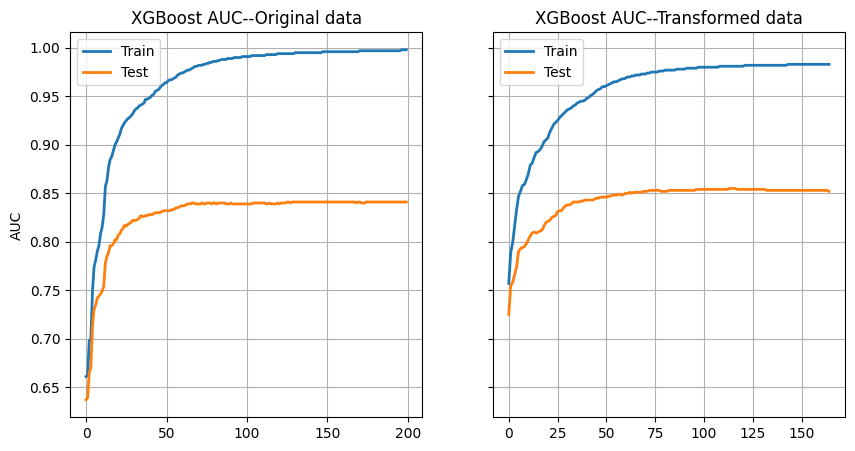

In [ ]:
# 9.1 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.2 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].grid()
ax[1].set_title('XGBoost AUC--Transformed data');
plt.show();

### Classification reports

In [ ]:
# 9.4
pred_orig = model_orig.predict(X_test)
pred_trans = model_trans.predict(test_X)

print("Note that the f1-score from transformed data is better than that from original data\n")
print(f"Classification report from original data: \n {classification_report(ytest,pred_orig)}")
print("\n==================\n")
print(f"Classification report from transformed data: \n {classification_report(ytest,pred_trans)}")



Note that the f1-score from transformed data is better than that from original data

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.34       474

    accuracy                           0.95      8193
   macro avg       0.82      0.61      0.65      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from transformed data: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.65      0.36      0.46       474

    accuracy                           0.95      8193
   macro avg       0.81      0.67      0.72      8193
weighted avg       0.94      0.95      0.95      8193



## PCAs with transformed data:
This is essentially to see how data looks in 2D

In [20]:
# 10.0 Check if any nulls in data
#       else we would impute using SimpleImputer:

train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # > 16800
pca_train = train_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns
pca_test  = test_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns

0

16000

In [21]:
# 10.1 Impute as test data has null values:

si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)

In [22]:
# 10.2 2D PCA with transformed train data.
#      Drop the initial cat_cols first:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(pca_train))
pca_test = pca.transform(ss.transform(pca_test))

In [23]:
# 10.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

In [24]:
# Save PCA data:
pca_train.to_pickle(amazondata + "pca_train.pkl")
pca_test.to_pickle(amazondata + "pca_test.pkl")

In [26]:
# Read back PCA data:
pca_train = pd.read_pickle(amazondata+"pca_train.pkl")
pca_test = pd.read_pickle(amazondata+"pca_test.pkl")

# Check
pca_train.shape   # (24576, 2)
pca_test.shape    # (8193, 2)
pca_train.head(2)
pca_test.head(2)


(24576, 2)

(8193, 2)

,pc0,pc1
0,-1.177185,0.985658
1,0.411435,-1.434906


,pc0,pc1
0,0.238064,-1.374182
1,-1.221170,0.927499


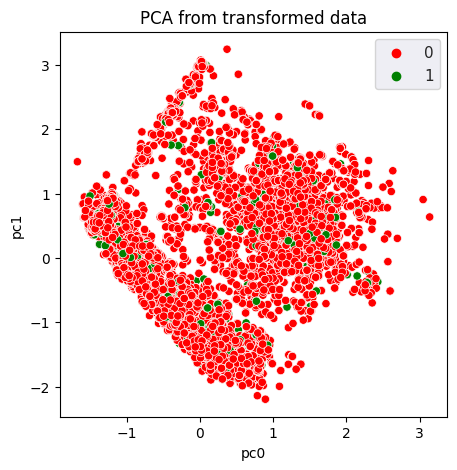

In [27]:
# 10.4 2D PCA plot from original train data:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
#plt.style.use("dark_background");
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_train,
                x= 'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;



## How good is 2-components PCA?
We perform predictive analytics with the 2-components PCA

In [28]:
# 11.0
model_pca = xgb.XGBClassifier( n_estimators= 1000,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 15,
                              subsample = 0.8,
                              random_state = rng
                           )


tr_X = pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    # binary classification problem
          )

# We need test_X for future
# So copy it:
test_X_pca =test_X.copy()


[00:00:07] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[00:00:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.57982	validation_1-auc:0.55481
[00:00:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-auc:0.58661	validation_1-auc:0.56101
[00:00:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.69377	validation_1-auc:0.66023
[00:00:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.69373	validation_1-auc:0.66234
[00:00:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.69382	validation_1-auc:0.66266
[00:00:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 134 extra nodes, 0 pruned nodes, 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [29]:
# Save estimator: model_trans
utils.savePythonObject(model_pca, "model_pca.pkl", estPath )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/estimators/model_pca.pkl


In [30]:
# Read back saved estimator:
model_pca = utils.restorePythonObject("model_pca.pkl", estPath )

### Learning plots

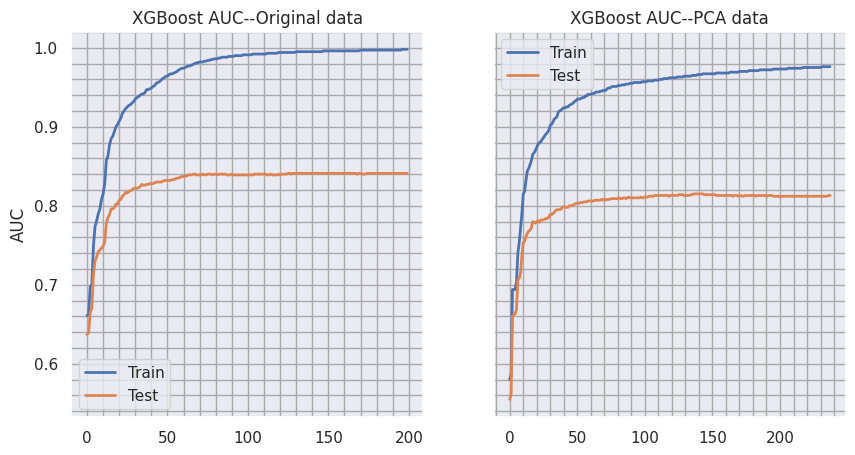

In [66]:
# 11.1 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both',color = 'darkgrey')
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 11.2 Modeling with transformed data:

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].grid(visible = True, which = 'both',color = 'darkgrey')
ax[1].minorticks_on()
ax[1].set_title('XGBoost AUC--PCA data');
plt.show();

### Classification reports 2-components PCA

In [38]:
# 11.3 Classification reports:

pred_orig = model_orig.predict(X_test)
pred_pca = model_pca.predict(test_X_pca)

print("Note that the difference in the two classification reports exist but not to great extent\n")
print(f"Classification report from original data: \n {classification_report(ytest,pred_orig)}")
print("\n==================\n")
print(f"Classification report from PCA data: \n {classification_report(ytest,pred_pca)}")



Note that the difference in the two classification reports exist but not to great extent

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.34       474

    accuracy                           0.95      8193
   macro avg       0.82      0.61      0.65      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from PCA data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.66      0.20      0.31       474

    accuracy                           0.95      8193
   macro avg       0.81      0.60      0.64      8193
weighted avg       0.94      0.95      0.93      8193



## tsne
Takes time..Does this plot show any pattern?

In [11]:
# 12.0 Instantiate class:
tsne = TSNE(perplexity = 30)  # perplexity of 30 gives best AUC
                              # Tried 20 and 50 also

# Fit and transform
ss = StandardScaler()
da = tsne.fit_transform(ss.fit_transform(train_trans.iloc[:, len(cat_cols) : ]))

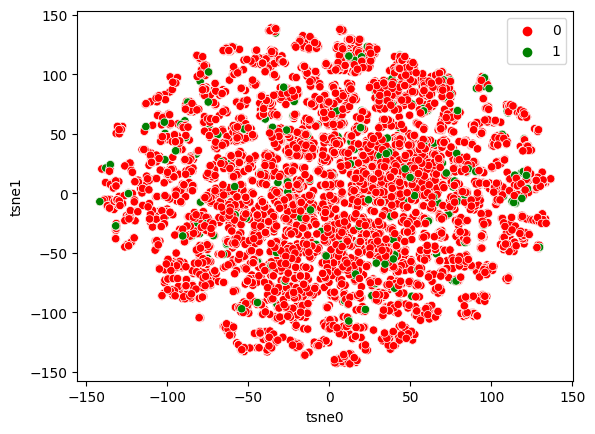

In [12]:
# 12.1 Plot tsne output:

colnames = ["tsne" + str(i) for i in range(da.shape[1])]
da = pd.DataFrame(da, columns = colnames)
plt.figure(100);
sns.scatterplot(x= da['tsne0'], y = da['tsne1'], hue = y_train.values, palette = ["red", "green"]);

## How good is tsne data in making predictions?

In [33]:
# 13,0 tsne class in sklearn does not have a transform method
# We cannot transform our test_trans data using tsne-object
# Let us partition tsne-transformed data itself:

Xtrain, Xtest, ytr, yte = train_test_split(da,
                                           y_train,
                                           test_size = 0.20,
                                           stratify= y_train,
                                           random_state = rng)

model_tsne = xgb.XGBClassifier( n_estimators= 250,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 6,
                           subsample = 0.8,
                           random_state = rng
                           )


tr_X =  Xtrain
test_X = Xtest



model_tsne.fit(tr_X, ytr,
          early_stopping_rounds = 100,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )

[00:02:43] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[00:02:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.62072	validation_1-auc:0.58830
[00:02:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.63748	validation_1-auc:0.60083
[00:02:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.65521	validation_1-auc:0.62148
[00:02:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.66899	validation_1-auc:0.62987
[00:02:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.67480	validation_1-auc:0.62933
[00:02:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [34]:
# Save estimator: model_trans
utils.savePythonObject(model_tsne, "model_tsne.pkl", estPath )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/estimators/model_tsne.pkl


In [ ]:
# Read back saved estimator:
model_tsne = utils.restorePythonObject("model_tsne.pkl", estPath )

### Learning plots

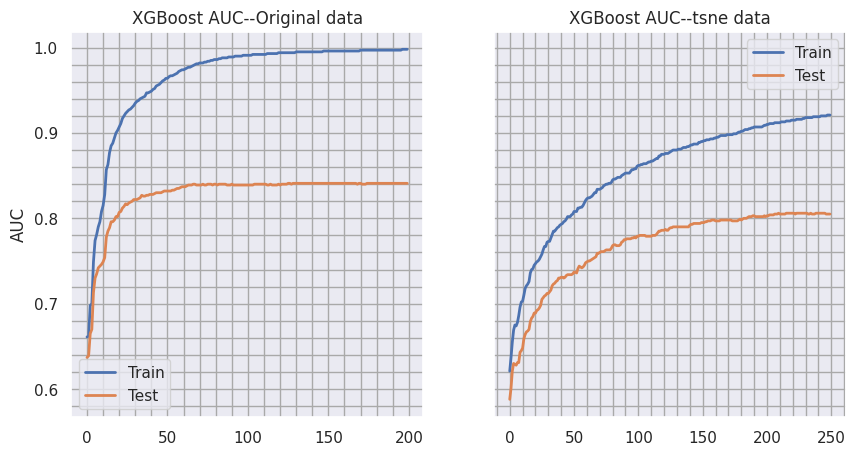

In [64]:
# 13.1 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both',color = 'darkgrey')
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_tsne.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].grid(visible = True, which = 'both',color = 'darkgrey')
ax[1].minorticks_on()
ax[1].set_title('XGBoost AUC--tsne data');
plt.show();

### Classification reports

In [36]:
# 13.2
pred_pca = model_pca.predict(test_X_pca)
pred_tsne = model_tsne.predict(test_X)

print("Note that the difference in the two classification reports exist. PCA modeling is superior\n")
print(f"Classification report from PCA data: \n {classification_report(ytest,pred_pca)}")
print("\n==================\n")
print(f"Classification report from tsne data: \n {classification_report(yte,pred_tsne)}")



Note that the difference in the two classification reports exist. PCA modeling is superior

Classification report from PCA data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.66      0.20      0.31       474

    accuracy                           0.95      8193
   macro avg       0.81      0.60      0.64      8193
weighted avg       0.94      0.95      0.93      8193



Classification report from tsne data: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      4631
           1       0.67      0.06      0.10       285

    accuracy                           0.94      4916
   macro avg       0.81      0.53      0.54      4916
weighted avg       0.93      0.94      0.92      4916



## Hyperparameter tuning--original data
We use optuna

In [ ]:
# 14.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test



# 14.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 14.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.3 Begin optimization
study.optimize(objective, n_trials=300)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)



[I 2023-07-01 12:55:06,244] A new study created in memory with name: no-name-45de03df-ee7a-4f48-aac8-7170942cb32f
[I 2023-07-01 12:55:13,652] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 13, 'learning_rate': 0.023688757383757104, 'n_estimators': 367, 'min_child_weight': 7, 'gamma': 1.7531002124219255e-06, 'subsample': 0.24751805570877924, 'colsample_bytree': 0.011893097719468289, 'reg_alpha': 0.00011180852096257971, 'reg_lambda': 0.011455530531391294}. Best is trial 0 with value: 0.0.
[I 2023-07-01 12:55:14,680] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 2, 'learning_rate': 0.01687459617145315, 'n_estimators': 297, 'min_child_weight': 2, 'gamma': 0.0043778869869839, 'subsample': 0.024882083946259764, 'colsample_bytree': 0.06105115000180729, 'reg_alpha': 1.7948921991254118e-06, 'reg_lambda': 3.3086604495450316e-06}. Best is trial 0 with value: 0.0.
[I 2023-07-01 12:55:15,249] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 6, 'learnin

In [ ]:
# 14.4 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

"""

Number of finished trials: 300

0.45714285714285713

    max_depth: 11
    learning_rate: 0.553336735296104
    n_estimators: 358
    min_child_weight: 5
    gamma: 1.0572155660272875e-06
    subsample: 0.9819637397077845
    colsample_bytree: 0.5445399139409933
    reg_alpha: 1.270314970367875e-05
    reg_lambda: 0.024201716886479412


"""


Number of finished trials: 300


0.45714285714285713

    max_depth: 11
    learning_rate: 0.553336735296104
    n_estimators: 358
    min_child_weight: 5
    gamma: 1.0572155660272875e-06
    subsample: 0.9819637397077845
    colsample_bytree: 0.5445399139409933
    reg_alpha: 1.270314970367875e-05
    reg_lambda: 0.024201716886479412


'\nNumber of finished trials: 300\n\n0.48721071863581\n\n    max_depth: 10\n    learning_rate: 0.560617208930175\n    n_estimators: 385\n    min_child_weight: 4\n    gamma: 3.9677811983420706e-07\n    subsample: 0.9926970202031392\n    colsample_bytree: 0.39634887845300765\n    reg_alpha: 0.13448504458692984\n    reg_lambda: 0.22566571338789548\n\n\n\n'

In [ ]:
# 15.0 Use these parameters in our estimator:
best_params = trial.params

model = xgb.XGBClassifier(**best_params)
model.fit(tr_X, y_train)

# 15.1 Make predictions and assessments:
y_pred_op = model.predict(test_X)
print(classification_report(y_test, y_pred_op))

"""
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7719
           1       0.56      0.39      0.46       474

    accuracy                           0.95      8193
   macro avg       0.76      0.68      0.71      8193
weighted avg       0.94      0.95      0.94      8193

"""



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5445399139409933, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0572155660272875e-06, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.553336735296104, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=358, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7719
           1       0.56      0.39      0.46       474

    accuracy                           0.95      8193
   macro avg       0.76      0.68      0.71      8193
weighted avg       0.94      0.95      0.94      8193



## Hyperparameter tuning--transformed data + SMOTE

### Generate synthetic data with SMOTE:

In [ ]:
# 16.0
# Train/test data
# Filter out initial cat_cols
# Keep only their numeric
# transformations

tr_X =  train_trans.iloc[:, len(cat_cols):]
test_X = test_trans.iloc[:, len(cat_cols):]
ytrain = y_train
ytest = y_test

# 16.1 Apply SMOTE
sm = SMOTE(random_state=rng)
X_res, y_res = sm.fit_resample(tr_X, ytrain)
X_res.shape  # (46306, 210)

(46306, 210)

### Train/test data after SMOTE

In [ ]:
# 16.2
tr_X = X_res
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_res
ytest = y_test


### Apply optuna for hyperparameter tuning


In [ ]:
# 17.0 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 17.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 17.2 Begin optimization
study.optimize(objective, n_trials=50)


[I 2023-07-02 08:05:44,441] A new study created in memory with name: no-name-9fe6aaa4-9bf1-4f8b-ab8d-3f9c2d2a8c10
[I 2023-07-02 08:05:54,826] Trial 0 finished with value: 0.16972767574414188 and parameters: {'max_depth': 1, 'learning_rate': 0.014415624626392115, 'n_estimators': 306, 'min_child_weight': 10, 'gamma': 1.0223422876375471e-07, 'subsample': 0.01689136979755906, 'colsample_bytree': 0.060729587002269846, 'reg_alpha': 1.882717467358324e-08, 'reg_lambda': 1.765957234413998e-06}. Best is trial 0 with value: 0.16972767574414188.
[I 2023-07-02 08:06:07,389] Trial 1 finished with value: 0.3545994065281899 and parameters: {'max_depth': 3, 'learning_rate': 0.4328227860113384, 'n_estimators': 208, 'min_child_weight': 7, 'gamma': 7.0699858325944e-05, 'subsample': 0.10204464673889625, 'colsample_bytree': 0.18251229755158205, 'reg_alpha': 5.4125098717979125e-05, 'reg_lambda': 5.038580139108422e-08}. Best is trial 1 with value: 0.3545994065281899.
[I 2023-07-02 08:06:21,732] Trial 2 finish

### Get optuna results

In [ ]:
# 18.0 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 18.1 Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5168986083499006

# 18.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# 18.3 Use these parameters in our estimator:
best_params = trial.params

"""
iter1 (pos class is 0)
----

Number of finished trials: 50

0.5452755905511811

    max_depth: 14
    learning_rate: 0.16713617697501307
    n_estimators: 132
    min_child_weight: 1
    gamma: 7.021017655710888e-05
    subsample: 0.6877378049820365
    colsample_bytree: 0.04897406890173597
    reg_alpha: 1.0163299827507004e-06
    reg_lambda: 1.1389177152979647e-05

iter2 (pos class is 1)
-----

Number of finished trials: 50

0.5274725274725276

    max_depth: 7
    learning_rate: 0.21759497624668758
    n_estimators: 240
    min_child_weight: 2
    gamma: 1.585241646411356e-07
    subsample: 0.6820691563940597
    colsample_bytree: 0.6756459048672927
    reg_alpha: 4.433669965130827e-06
    reg_lambda: 0.00046256097212958467
"""




Number of finished trials: 50


0.5274725274725276

    max_depth: 7
    learning_rate: 0.21759497624668758
    n_estimators: 240
    min_child_weight: 2
    gamma: 1.585241646411356e-07
    subsample: 0.6820691563940597
    colsample_bytree: 0.6756459048672927
    reg_alpha: 4.433669965130827e-06
    reg_lambda: 0.00046256097212958467


'\nNumber of finished trials: 50\n\n0.5452755905511811\n\n    max_depth: 14\n    learning_rate: 0.16713617697501307\n    n_estimators: 132\n    min_child_weight: 1\n    gamma: 7.021017655710888e-05\n    subsample: 0.6877378049820365\n    colsample_bytree: 0.04897406890173597\n    reg_alpha: 1.0163299827507004e-06\n    reg_lambda: 1.1389177152979647e-05\n\n\n\n'

### xgboost modeling with tuned hyperparameters

In [ ]:
# 18.4
model = xgb.XGBClassifier(**best_params)
model.fit(tr_X, ytrain)

# 18.5 Make predictions and assessments:
y_pred = model.predict(test_X)
print(classification_report(ytest, y_pred))



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6756459048672927, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.585241646411356e-07, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.21759497624668758, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=240, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7719
           1       0.50      0.56      0.53       474

    accuracy                           0.94      8193
   macro avg       0.74      0.76      0.75      8193
weighted avg       0.95      0.94      0.94      8193



In [ ]:
"""
iter1 (pos class is 0)
----

                precision   recall  f1-score   support

           0       0.51      0.58      0.55       474
           1       0.97      0.97      0.97      7719

    accuracy                           0.94      8193
   macro avg       0.74      0.78      0.76      8193
weighted avg       0.95      0.94      0.95      8193


iter 2: (pos class is 1)
-----------------------


                precision    recall  f1-score   support

           0       0.97      0.97      0.97      7719
           1       0.50      0.56      0.53       474

    accuracy                           0.94      8193
   macro avg       0.74      0.76      0.75      8193
weighted avg       0.95      0.94      0.94      8193

"""

## PCA and SMOTEENN
Perform SMOTEENN on PCA data with total explained variance of 95%.  
SMOTEEENN consumes time and hence on PCA and not on `train_trans`

#### First get 95% variance PCA
We want as many principal components as would give us 95% variance

In [52]:
# 19.0 Check if any nulls in data
#       else we would impute using SimpleImputer:

train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # > 16800
pca_train_full = train_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns
pca_test_full  = test_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns

0

16000

In [53]:
# 19.1 Impute as test data has null values:

si = SimpleImputer(strategy = 'median')
pca_train_full[:] = si.fit_transform(pca_train_full)
pca_test_full[:] = si.transform(pca_test_full)

In [54]:
# 19.2 PCA with transformed train data.
#      Drop the initial cat_cols first:

pca = PCA(n_components= 0.95, whiten= True, random_state = None)
ss = StandardScaler()
pca_train_full = pca.fit_transform(ss.fit_transform(pca_train_full))
pca_test_full = pca.transform(ss.transform(pca_test_full))

In [55]:
# 19.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train_full = pd.DataFrame(pca_train_full, columns = colnames)
pca_test_full = pd.DataFrame(pca_test_full, columns = colnames)

# 19.3.1 Data shapes
pca_train_full.shape  # (24576, 39)
pca_test_full.shape   # (8193, 39)

(24576, 39)

(8193, 39)

#### Also save PCA data to gdrive and read it back
This is for later use

In [56]:
# 19.3.2. Save PCA data for later use:

pca_train_full.to_pickle(amazondata + "pca_train_full.pkl")
pca_test_full.to_pickle(amazondata + "pca_test_full.pkl")

In [57]:
# Read back the above saved data:
#datafolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"

pca_train_full = pd.read_pickle(amazondata + "pca_train_full.pkl")
pca_test_full = pd.read_pickle(amazondata + "pca_test_full.pkl")

# Check
pca_train_full.shape  # (24576, 39)
pca_test_full.shape   # (8193, 39)
pca_train_full.head(2)

(24576, 39)

(8193, 39)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38
0,-1.177204,0.985659,0.844031,1.546484,-1.287232,0.647936,0.645013,-1.601013,-1.056423,-2.041391,...,0.606227,2.357795,0.654308,0.685968,-1.510676,0.854635,-0.616610,1.107696,1.578789,-1.012790
1,0.411428,-1.434911,-0.506739,-1.608989,-0.095674,1.012032,-0.302223,-0.386375,0.404760,-0.906226,...,0.812353,-1.283172,-0.201607,-0.304102,-0.937721,0.591023,-0.238826,-0.146825,-1.452722,0.867205


#### Apply `SMOTEENN` on PCA data
Get resampled data

In [58]:
# 19.4 Use SMOTEENN to perform resampling:

from imblearn.combine import SMOTEENN
sm = SMOTEENN()
X_res_sme, y_res_sme = sm.fit_resample(pca_train_full,y_train)

# 19.4.1
X_res_sme.shape  # (37691, 39)/(37892, 39)/(37708, 39)
y_res_sme.shape  # (37691,)/(37892, )/(37708, )
y_res_sme.value_counts(normalize = True)

(37708, 39)

(37708,)

0    0.543041
1    0.456959
Name: action, dtype: float64

#### Perform xgboost modeling on PCA resampled data
Resamplng was done using `SMOTEENN`

In [59]:
# 19.5 xgboost modeling on resampled data:

model_sme = xgb.XGBClassifier( n_estimators= 300,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 15,
                                subsample = 0.9,
                                random_state = rng,
                                reg_lambda = 1.5,
                            )


tr_X =   X_res_sme
test_X = pca_test_full
ytr = y_res_sme
yte = y_test


model_sme.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )


[00:13:04] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[00:13:06] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1260 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.97795	validation_1-auc:0.78192
[00:13:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1226 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.98779	validation_1-auc:0.79334
[00:13:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1070 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.99159	validation_1-auc:0.80521
[00:13:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1014 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.99264	validation_1-auc:0.81055
[00:13:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1030 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.99299	validation_1-auc:0.81639
[00:13:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1264 extra nodes, 0 pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Save estimator: model_sme
utils.savePythonObject(model_sme, "model_sme.pkl", estPath )


In [ ]:
# Read back saved estimator:
model_sme = utils.restorePythonObject("model_sme.pkl", estPath )

In [ ]:
# 19.5.0 Best scores:

model_sme.best_score    # 0.86581100/0.839181962
print("\n")
model_sme.best_iteration # 222/95

0.8391819626402711

95

In [ ]:
# 19.5.1 Classification reports:
#        Recall is quite high

pred_sme = model_sme.predict(pca_test_full)
print(classification_report(y_test,pred_sme))


              precision    recall  f1-score   support

           0       0.98      0.92      0.94      7719
           1       0.32      0.64      0.42       474

    accuracy                           0.90      8193
   macro avg       0.65      0.78      0.68      8193
weighted avg       0.94      0.90      0.91      8193



In [ ]:
"""
                  precision    recall  f1-score   support

           0       0.98      0.92      0.94      7719
           1       0.32      0.64      0.42       474

    accuracy                           0.90      8193
   macro avg       0.65      0.78      0.68      8193
weighted avg       0.94      0.90      0.91      8193

                 precision    recall  f1-score   support

           0       0.98      0.92      0.94      7719
           1       0.32      0.64      0.42       474

    accuracy                           0.90      8193
   macro avg       0.65      0.78      0.68      8193
weighted avg       0.94      0.90      0.91      8193

"""

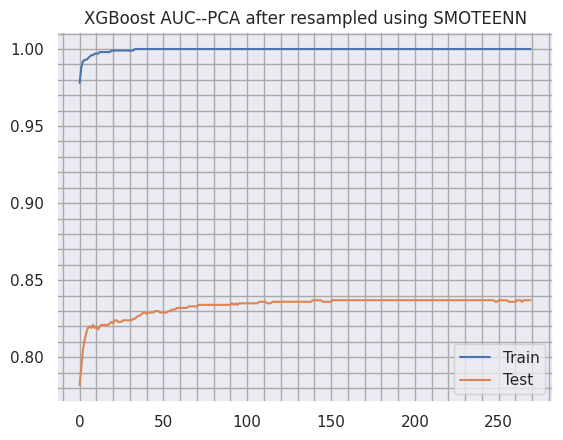

In [62]:
# 19.5.2 Learning curve after modeling reampled data:
fig,ax = plt.subplots(1,1)
results = model_sme.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax.plot(x_axis, np.round(results['validation_0']['auc'],3),  label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3),  label='Test');
ax.legend();
ax.grid(visible = True, which = 'both',color = 'darkgrey')
ax.minorticks_on()
ax.set_title('XGBoost AUC--PCA after resampled using SMOTEENN');
plt.show();

## Distribution of transformed features:
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

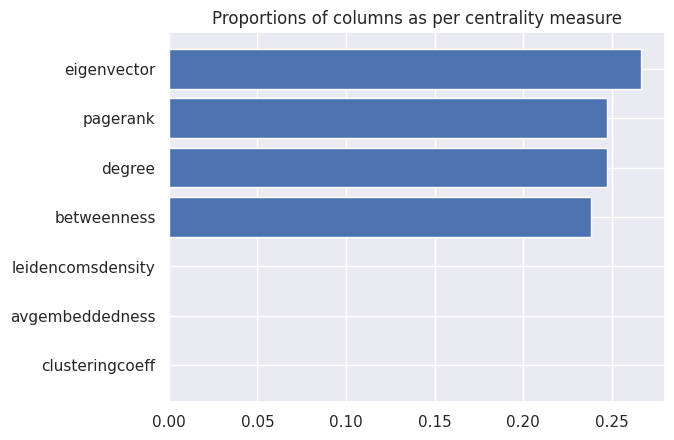

In [67]:
# 20.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [70]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 178'

'Columns whose impt is 0: 32'

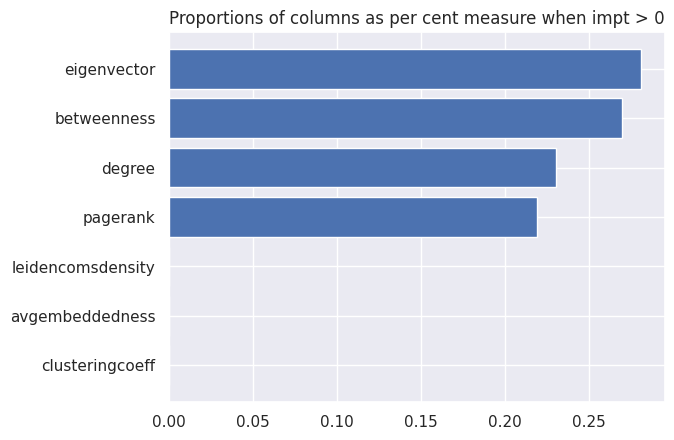

In [71]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [72]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [73]:
# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

pr_rolefamily_ck_roledeptname      0.030017
deg_rolefamily_ck_roledeptname     0.018069
eig_rolefamily_ck_rolerollupOne    0.017100
pr_rolerollupOne_ck_roletitle      0.012642
bet_rolerolluptwo_ck_rolecode      0.010508
Name: imp, dtype: float32

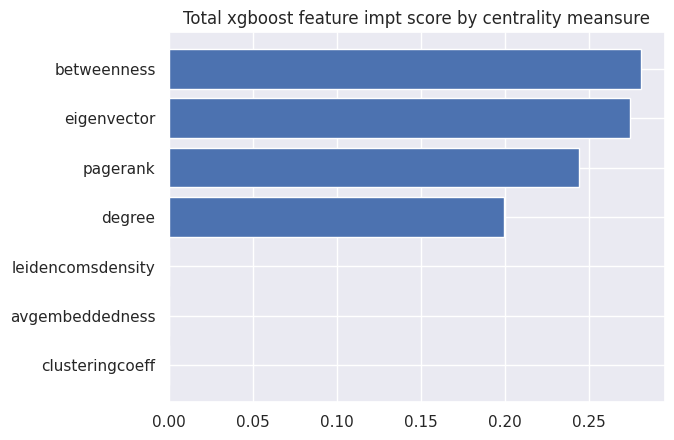

In [74]:
# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [75]:
# 21.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [78]:
# 21.1 Path where .gml files are placed:
amazongraphs = Path(amazongraphs)
filelist = sorted(list(amazongraphs.iterdir()))
filelist[5:10]   # mgrid_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_bigraph_rolerolluptwo.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_bigraph_roletitle.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_projected_rolecode.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_projected_roledeptname.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonemp/models/mgrid_projected_rolefamily.gml')]

### Read data files from gdrive:

In [80]:
# 21.2 Read original and transformed data:

# Oriinal data:
X_train = pd.read_pickle(amazondata + "X_train.pkl")
X_test = pd.read_pickle(amazondata + "X_test.pkl")
y_train = pd.read_pickle(amazondata + "y_train.pkl")
y_test = pd.read_pickle(amazondata + "y_test.pkl")

# 21.2.1 Transformed data:
train_trans = pd.read_pickle(amazondata+ "train_trans.pkl")
test_trans = pd.read_pickle(amazondata + "test_trans.pkl")

In [81]:
# 21.3 check data files:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)
y_train.head(2)
y_test.head(2)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,18044,117961,118386,118522,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.036717,0.057254,0.083832,0.212401,0.009444,0.007352,0.029940,3.853129e-17,0.003087
1,51345,117961,118052,120417,118702,125047,118704,118705,0.421883,0.024354,...,0.005207,0.008848,0.010622,0.023952,0.010817,0.004082,0.003733,0.005988,-2.580549e-18,0.003087


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,52687,117961,117962,117904,128230,302830,4673,128231,0.421883,0.024354,...,0.005049,0.002312,-0.033409,0.005988,-1.413484e-18,0.003894,0.000000,0.008982,-9.564134e-18,0.003087
1,3889,117961,118386,121668,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.036717,0.057254,0.083832,2.124007e-01,0.009444,0.007352,0.029940,3.853129e-17,0.003087


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17277,4675,18044,117961,118386,118522,118321,117906,290919,118322
9292,73495,51345,117961,118052,120417,118702,125047,118704,118705


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
12953,110357,52687,117961,117962,117904,128230,302830,4673,128231
17348,41269,3889,117961,118386,121668,118321,117906,290919,118322


17277    0
9292     1
Name: action, dtype: int64

12953    0
17348    0
Name: action, dtype: int64

In [82]:
# 21.4 Excludes 'resource'
cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

### Display graphs--Bigraphs and Projected

In [83]:
# 21.5 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_projected' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['rolerollupOne_bigraph_mgrid.gml',
 'rolerollupOne_bigraph_rolecode.gml',
 'rolerollupOne_bigraph_roletitle.gml',
 'rolerollupOne_bigraph_rolefamily.gml',
 'rolerollupOne_bigraph_roledeptname.gml',
 'rolerollupOne_bigraph_rolerolluptwo.gml',
 'rolerollupOne_bigraph_rolefamilydesc.gml']



====



['rolerollupOne_projected_mgrid.gml',
 'rolerollupOne_projected_rolecode.gml',
 'rolerollupOne_projected_roletitle.gml',
 'rolerollupOne_projected_rolefamily.gml',
 'rolerollupOne_projected_roledeptname.gml',
 'rolerollupOne_projected_rolerolluptwo.gml',
 'rolerollupOne_projected_rolefamilydesc.gml']

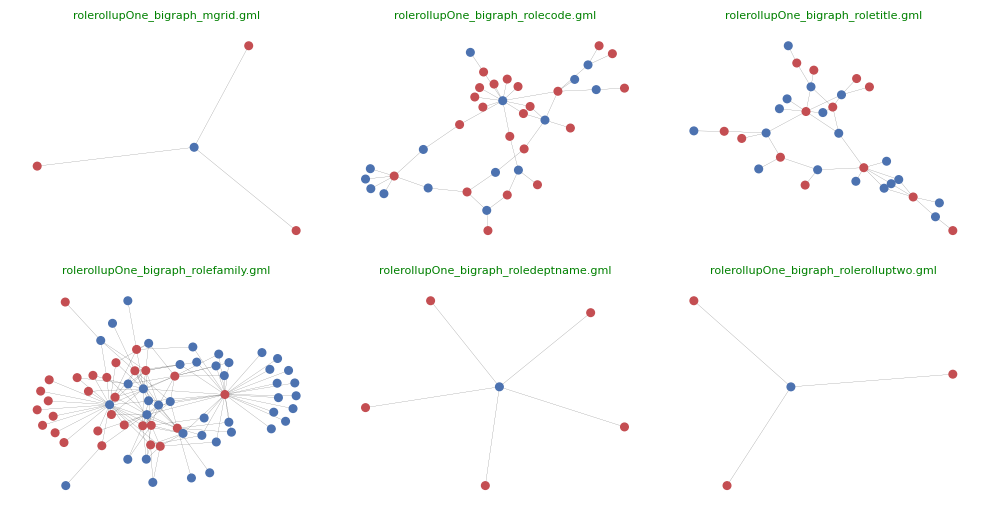

In [85]:
# 21.6 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                amazongraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

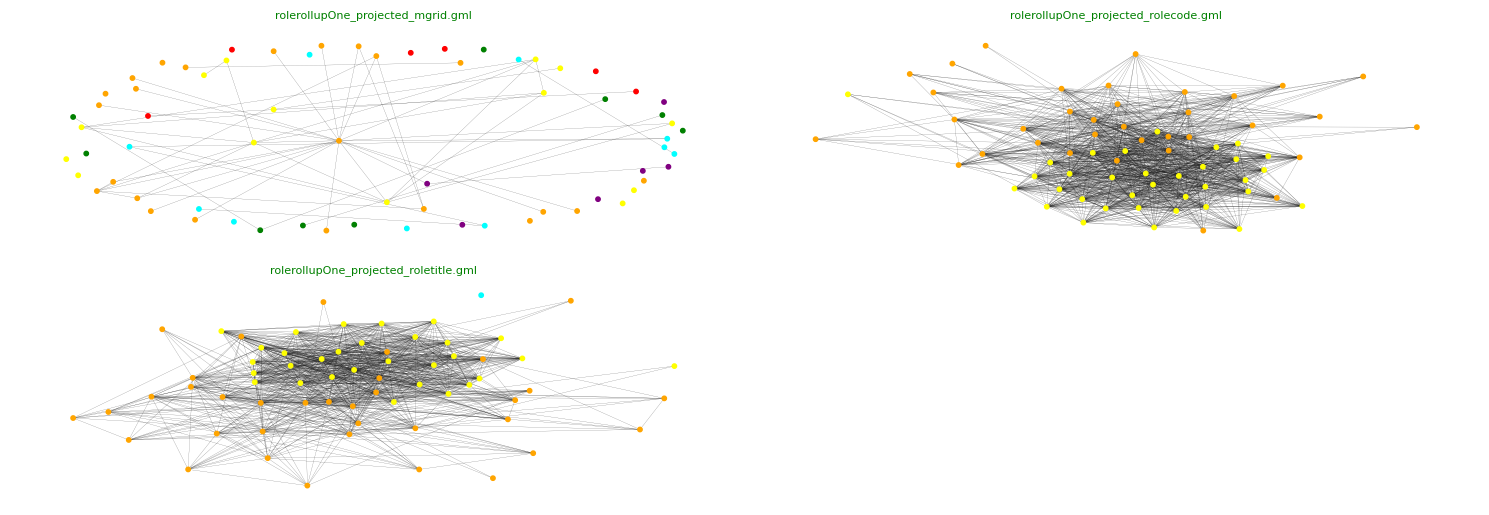

In [86]:
# 21.7 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

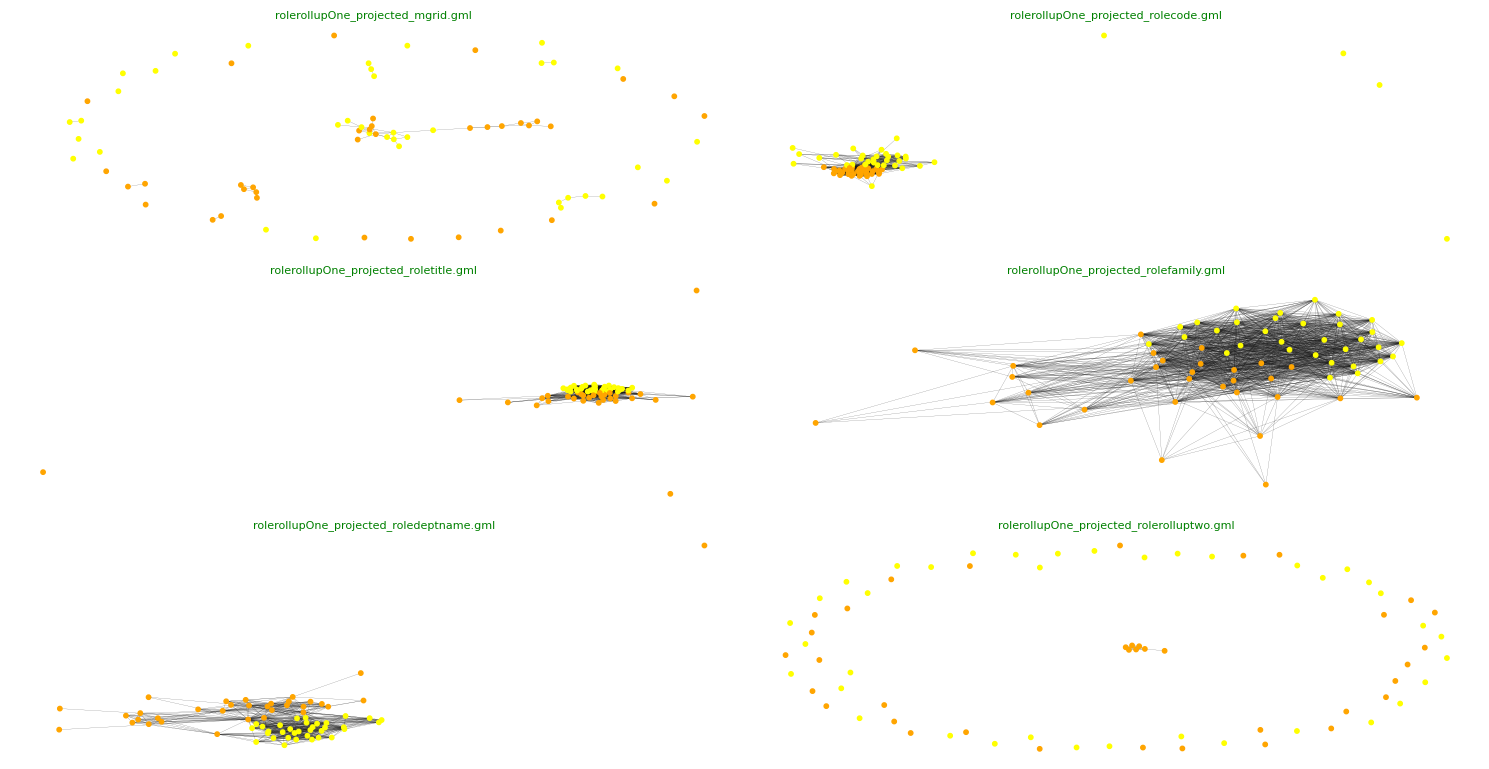

In [87]:
# 21.7.1 Community visualization using
#        kernighan_lin_bisection algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.kernighan_lin_bisection,
                                   node_size = 10,
                                   ax = ax,
                                   withLabels = False,
                                   title = prj,
                                   takeGraphSample = True
                                   );
    plt.tight_layout();

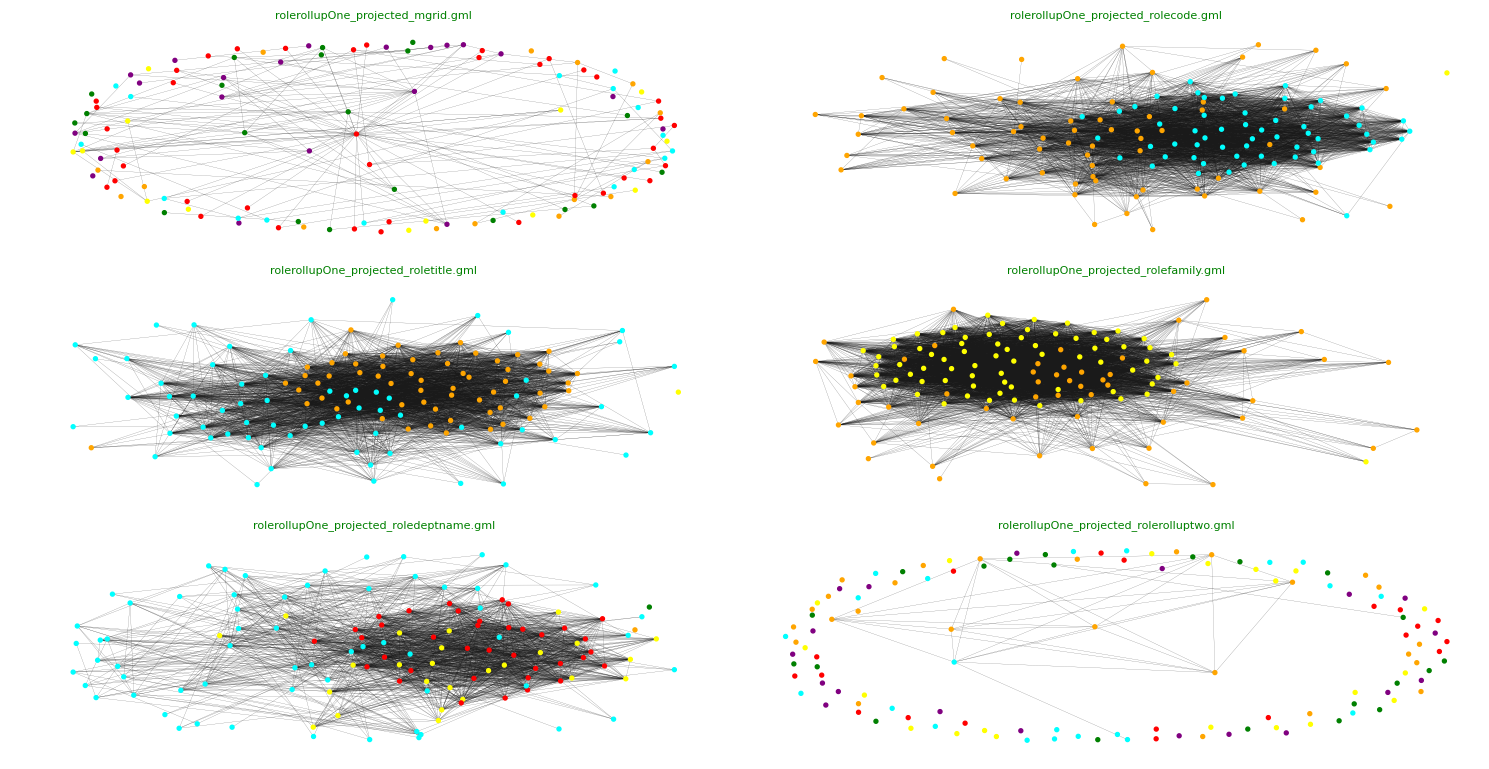

In [88]:
# 21.7.2 Community visualization using
#        louvain_communities algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.louvain_communities,
                                   node_size = 8,
                                   k =1.5,  # For spring_layout, to avoid crowding of nodes
                                   ax = ax,
                                   withLabels = False,
                                   title = prj
                                   );
    plt.tight_layout();

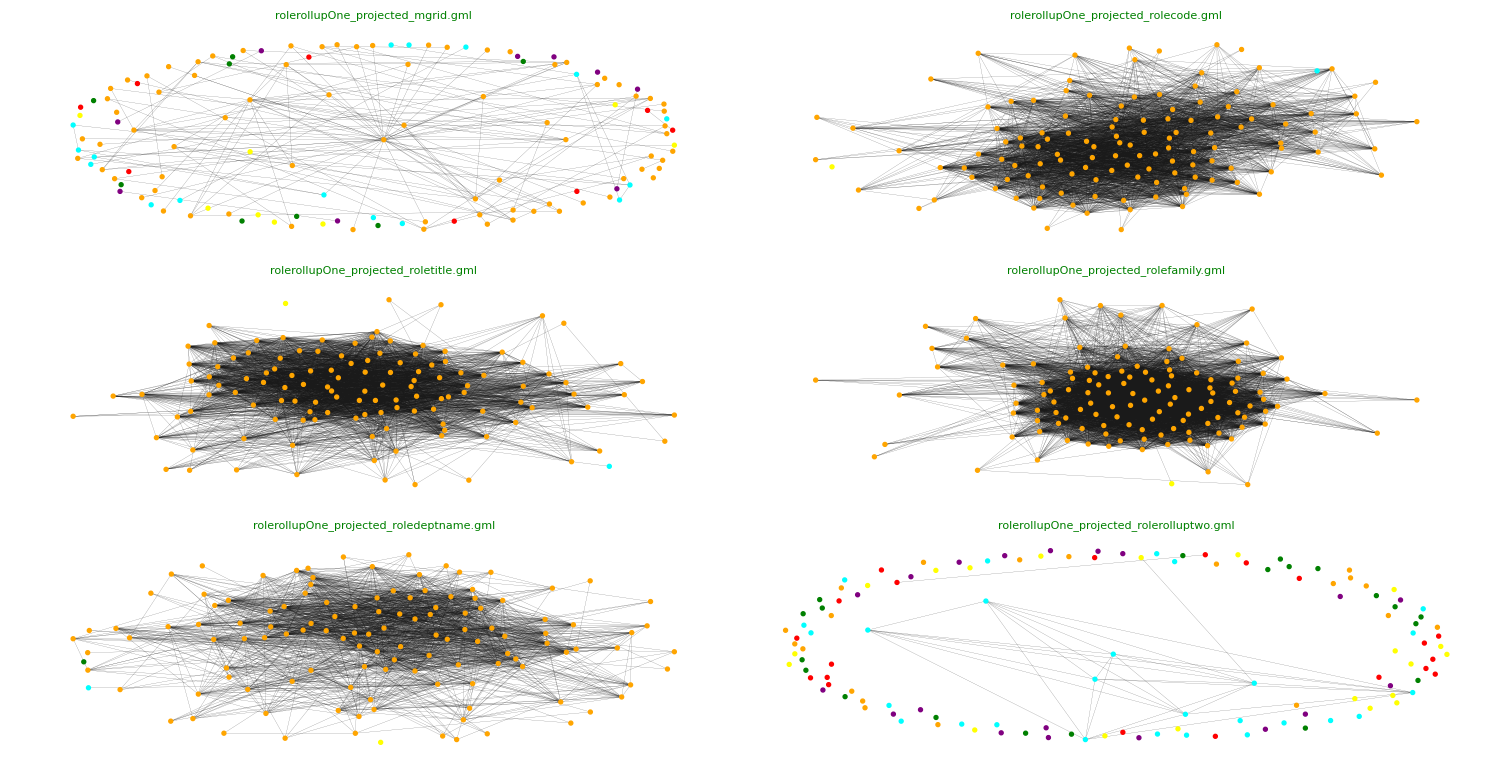

In [89]:
# 21.7.3 Community visualization using
#        girvan_newman algo:
import itertools
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.girvan_newman,
                                   node_size = 8,
                                   k = 1.5,  # For spring_layout, greater node distance
                                   ax = ax,
                                   withLabels = False,
                                   title = prj
                                   );
    plt.tight_layout();

## Transform original data to communities data:
Takes time....

In [90]:
# 22.0 Transform each column bin as per the community
#       to which it belongs:

# 22.1 Our transformed discrete cols are:
columnNames = cat_cols

# 22.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 22.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/amazonemp/models"

# 22.4 Perform transformation of both X_train and X_test:
# 22.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 22.4.2 PErform transformation to community structure
for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,amazongraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,amazongraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  mgrid_projected_rolerollupOne.gml
Reading file:  mgrid_projected_rolerolluptwo.gml
Reading file:  mgrid_projected_roledeptname.gml
Reading file:  mgrid_projected_roletitle.gml
Reading file:  mgrid_projected_rolefamilydesc.gml
Reading file:  mgrid_projected_rolefamily.gml
Reading file:  mgrid_projected_rolecode.gml
Reading file:  rolerollupOne_projected_mgrid.gml
Reading file:  rolerollupOne_projected_rolerolluptwo.gml
Reading file:  rolerollupOne_projected_roledeptname.gml
Reading file:  rolerollupOne_projected_roletitle.gml
Reading file:  rolerollupOne_projected_rolefamilydesc.gml
Reading file:  rolerollupOne_projected_rolefamily.gml
Reading file:  rolerollupOne_projected_rolecode.gml
Reading file:  rolerolluptwo_projected_mgrid.gml
Reading file:  rolerolluptwo_projected_rolerollupOne.gml
Reading file:  rolerolluptwo_projected_roledeptname.gml
Reading file:  rolerolluptwo_projected_roletitle.gml
Reading file:  rolerolluptwo_projected_role

In [93]:
# 23.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (24576, 52)
print("\n--\n")
fg_te[0].shape   # (8193, 52)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(24576, 52)


--



(8193, 52)


--



,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17277,0,5,5,0,1,0,0,0,0,0,...,1,2,2,0,0,1,0,0,4,7
9292,0,8,19,2,0,2,2,0,0,0,...,0,1,0,2,2,0,1,1,0,43


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
12953,0.0,11.0,8.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0,1,0,14,1.0,0.0,1.0,0.0,11.0,30.0
17348,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,2,2,0,0.0,1.0,0.0,0.0,4.0,7.0


In [91]:
# 23.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 22.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (24576, 52)
Datashape after processing: (24576, 52)


## Save community transformed data to gdrive
We can analyse it at peace

In [92]:
# 24. Save the list to gdrive:
#myfolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"
utils.savePythonObject(fg_tr, "fg_tr.pkl", amazondata)
utils.savePythonObject(fg_te, "fg_te.pkl", amazondata)

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/fg_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/fg_te.pkl


## Read back community transformed data from gdrive

In [94]:
# 24.1
fg_tr = utils.restorePythonObject( "fg_tr.pkl", amazondata )
fg_te = utils.restorePythonObject( "fg_te.pkl", amazondata )

In [95]:
# 24.2 Check restoration:
fg_tr[0].head(2)
fg_te[0].head(2)

,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17277,0,5,5,0,1,0,0,0,0,0,...,1,2,2,0,0,1,0,0,4,7
9292,0,8,19,2,0,2,2,0,0,0,...,0,1,0,2,2,0,1,1,0,43


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
12953,0.0,11.0,8.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0,1,0,14,1.0,0.0,1.0,0.0,11.0,30.0
17348,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,2,2,0,0.0,1.0,0.0,0.0,4.0,7.0


## Check data columns
Our predictors should not have target columns

In [96]:
# 24.3 Check again if target is in predictors!

'target' in list(fg_tr[0].columns)
'target' in list(fg_te[0].columns)
'action' in list(fg_tr[0].columns)
'action' in list(fg_te[0].columns)

False

False

False

False

## xgboost modeling from community indicators:

In [97]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[02:07:04] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:07:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.71813	validation_1-auc:0.67768
[02:07:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.77324	validation_1-auc:0.73191
[02:07:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.76974	validation_1-auc:0.72593
[02:07:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.77801	validation_1-auc:0.72860
[02:07:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.80248	validation_1-auc:0.74932
[02:07:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [98]:
# Save estimator: model_trans_commu
utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", estPath )

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/estimators/model_trans_commu.pkl


In [99]:
# Read back saved estimator:
model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", estPath )

### Learning curve

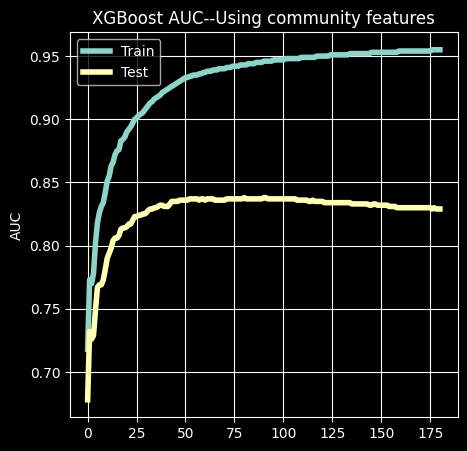

In [100]:
# 25.1 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


### Classification report

In [101]:
# 25.2 Classification reports:

pred_orig = model_orig.predict(X_test)
pred_comm = model_trans_commu.predict(test_X)

print("Note that the difference in the two classification reports exist but not to great extent\n")
print(f"Classification report from original data: \n {classification_report(y_test,pred_orig)}")
print("\n==================\n")
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Note that the difference in the two classification reports exist but not to great extent

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.34       474

    accuracy                           0.95      8193
   macro avg       0.82      0.61      0.65      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from community data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.58      0.22      0.32       474

    accuracy                           0.95      8193
   macro avg       0.77      0.61      0.65      8193
weighted avg       0.93      0.95      0.93      8193



### PCA using community indicators:

In [102]:
# 25.3 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17277,0,5,5,0,1,0,0,0,0,0,...,1,2,2,0,0,1,0,0,4,7
9292,0,8,19,2,0,2,2,0,0,0,...,0,1,0,2,2,0,1,1,0,43
5774,0,11,28,0,0,0,0,0,0,0,...,0,0,2,0,0,1,1,0,4,20


In [103]:
# 25.4 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))

# 24.5 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

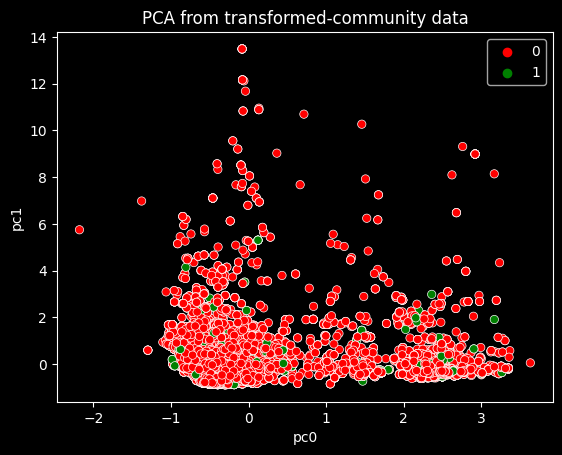

In [104]:
# 25.6 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x=  commu_pca.pc0,
                y = commu_pca.pc1,
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

In [105]:
# 26.0
train_trans = train_trans.reset_index(drop = True)
test_trans = test_trans.reset_index(drop = True)

# 26.1 Reset index
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [106]:
# 26.2 Check for nulls:
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 16884

0

16000

In [107]:
# 26.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [111]:
# 26.4Get target data col. Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [112]:
# 27.0 Derive unit vectors:

p = Path(unitvecfolder)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 26.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecfolder,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/amazonemp/unitvec/'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [113]:
# 27.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecfolder)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecfolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/unitvec/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/unitvec/vec_te.pkl


## Restore unit-vectors files from gdrive

In [114]:
# 27.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecfolder)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecfolder)

## Using unit vectors to transform train/test data

In [115]:
# 28.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for mgrid for train data
Performing PCA for mgrid for test data
Performing PCA for rolerollupOne for train data
Performing PCA for rolerollupOne for test data
Performing PCA for rolerolluptwo for train data
Performing PCA for rolerolluptwo for test data
Performing PCA for roledeptname for train data
Performing PCA for roledeptname for test data
Performing PCA for roletitle for train data
Performing PCA for roletitle for test data
Performing PCA for rolefamilydesc for train data
Performing PCA for rolefamilydesc for test data
Performing PCA for rolefamily for train data
Performing PCA for rolefamily for test data
Performing PCA for rolecode for train data
Performing PCA for rolecode for test data
Concatenating train data
Concatenating test data
Done......


In [116]:
# 28.1

cctr.head(3)
ccte.head(3)

,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.639122,1.634540,1.544815,-0.154850,-2.877786,-0.066982,-0.004238,-0.086551,-0.279136,2.444091,...,-0.081208,0.361309,-3.013886,-0.357514,0.161407,-0.360339,2.748152,-1.340382,-0.132131,0.508355
1,-1.208024,-3.129842,-0.220301,-0.427796,-2.877773,-0.066943,-0.005110,-0.086764,2.194898,1.375510,...,-0.569998,1.057524,4.207465,-2.240399,0.900906,-0.025272,-2.987618,-1.014347,0.600104,-0.533666
2,-0.519721,-0.646018,-1.882423,0.438179,-2.877772,-0.066961,-0.004160,-0.087042,0.250676,-0.800737,...,0.264644,-0.427496,3.608279,-2.619795,0.472010,0.581469,-1.136021,-0.977808,0.615853,-0.797645


,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.369874,-3.127349,-0.271803,-0.499491,-2.877773,-0.066965,-0.004153,-0.086964,0.250675,-0.800721,...,0.597435,-1.507755,6.056538,-2.334090,1.574121,-0.069030,-2.599953,-1.620415,1.046913,-0.604449
1,-1.526044,1.798232,1.439904,0.011055,-2.877773,-0.066965,-0.004153,-0.086964,-0.279138,2.444024,...,-0.081298,0.361183,-3.013867,-0.357494,0.161242,-0.360109,2.748135,-1.340544,-0.132279,0.508272
2,-1.689302,1.377038,1.876173,0.068553,-2.877773,-0.066965,-0.004153,-0.086964,2.876556,-0.219137,...,0.101360,-0.572861,-3.013867,-0.357494,0.161242,-0.360109,2.231602,-1.145420,-0.162879,-0.193770


In [117]:
# 28.2

cctr.shape   #  (24576, 32)
ccte.shape   #  (8193, 32)

(24576, 32)

(8193, 32)

In [118]:
# 28.3

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:20]))
print(list(cctr.columns[20:]))

['pcmgrid0', 'pcmgrid1', 'pcmgrid2', 'pcmgrid3', 'pcrolerollupOne0', 'pcrolerollupOne1', 'pcrolerollupOne2', 'pcrolerollupOne3', 'pcrolerolluptwo0', 'pcrolerolluptwo1']
['pcrolerolluptwo2', 'pcrolerolluptwo3', 'pcroledeptname0', 'pcroledeptname1', 'pcroledeptname2', 'pcroledeptname3', 'pcroletitle0', 'pcroletitle1', 'pcroletitle2', 'pcroletitle3']
['pcrolefamilydesc0', 'pcrolefamilydesc1', 'pcrolefamilydesc2', 'pcrolefamilydesc3', 'pcrolefamily0', 'pcrolefamily1', 'pcrolefamily2', 'pcrolefamily3', 'pcrolecode0', 'pcrolecode1', 'pcrolecode2', 'pcrolecode3']


In [125]:
# Save cctr/ccte to gdrive
cctr.to_pickle(amazondata + "cctr.pkl")
ccte.to_pickle(amazondata + "ccte.pkl")

In [128]:
# Read back cctr/ccte
cctr = pd.read_pickle(amazondata + "cctr.pkl")
ccte = pd.read_pickle(amazondata + "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (24576, 32)
ccte.shape # (8193, 32)

,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.639122,1.634540,1.544815,-0.154850,-2.877786,-0.066982,-0.004238,-0.086551,-0.279136,2.444091,...,-0.081208,0.361309,-3.013886,-0.357514,0.161407,-0.360339,2.748152,-1.340382,-0.132131,0.508355
1,-1.208024,-3.129842,-0.220301,-0.427796,-2.877773,-0.066943,-0.005110,-0.086764,2.194898,1.375510,...,-0.569998,1.057524,4.207465,-2.240399,0.900906,-0.025272,-2.987618,-1.014347,0.600104,-0.533666


,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.369874,-3.127349,-0.271803,-0.499491,-2.877773,-0.066965,-0.004153,-0.086964,0.250675,-0.800721,...,0.597435,-1.507755,6.056538,-2.334090,1.574121,-0.069030,-2.599953,-1.620415,1.046913,-0.604449
1,-1.526044,1.798232,1.439904,0.011055,-2.877773,-0.066965,-0.004153,-0.086964,-0.279138,2.444024,...,-0.081298,0.361183,-3.013867,-0.357494,0.161242,-0.360109,2.748135,-1.340544,-0.132279,0.508272


(24576, 32)

(8193, 32)

## xgboost modeling

In [127]:
# 28.4 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 250,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[02:21:07] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:21:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.71526	validation_1-auc:0.68199
[02:21:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.75789	validation_1-auc:0.73018
[02:21:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.79055	validation_1-auc:0.75874
[02:21:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.80022	validation_1-auc:0.76454
[02:21:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.80192	validation_1-auc:0.76639
[02:21:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [120]:
# Save estimator: model_vec
utils.savePythonObject(model_vec, "model_vec.pkl", estPath )
# Read back saved estimator:
model_vec = utils.restorePythonObject("model_vec.pkl", estPath )

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonemp/estimators/model_vec.pkl


In [121]:
# 28.5 Best scores:

model_vec.best_score   # 0.8518154556431797
print("\n")
model_vec.best_iteration  # 59


0.8518154556431797

59

In [122]:
# 28.6 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.68      0.29      0.41       474

    accuracy                           0.95      8193
   macro avg       0.82      0.64      0.69      8193
weighted avg       0.94      0.95      0.94      8193



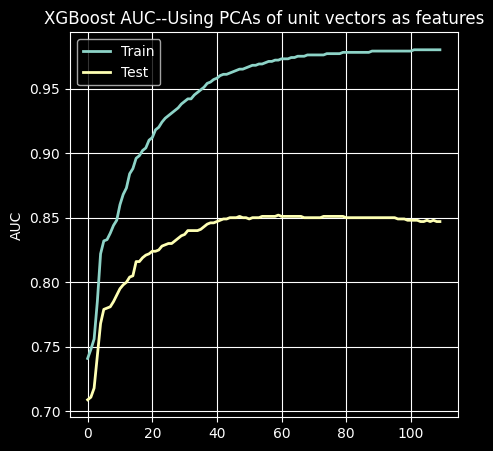

In [124]:
# 28.7 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using PCAs of unit vectors as features");


In [ ]:
from sklearn.cluster import  KMeans
from sklearn.pipeline import Pipeline

In [ ]:
train_trans['target'] = y_train

vec_trx,_ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
########### Done ##############3